
# Fully-Connected Networks and Convoluntional Neural Networks

# Environment Set Up

In [ ]:
! pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 104kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


Mount your google drive in google colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import torch
import time
import torch.nn as nn
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import sys
import os
prefix = '/content/gdrive/My Drive/'

customized_path_to_your_data = 'data'
sys_path = os.path.join(prefix, customized_path_to_your_data)
sys.path.append(sys_path)

# Pytorch basics






Simply put, PyTorch is a **Tensor** library like Numpy. These two libraries similarly provide useful and efficient APIs for you to deal with your tensor data. What really differentiate PyTorch from Numpy are the following two features:
1. Numerical operations that can **run on GPUs** (more than 10x speedup)
2. Automatic differentiation for building and training neural networks

## 1.1. `nn` Module
Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In PyTorch, the nn package serves this purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

Now, let's see how our simple NN could be implemented using the nn module.

In [ ]:
import torch
import torch.nn as nn
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):

    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

iteration 99: 2.9120113849639893
iteration 199: 0.05105302855372429
iteration 299: 0.001618186361156404
iteration 399: 6.281122477957979e-05
iteration 499: 2.6908519430435263e-06


So far, we have been updating the model parameters manually with `torch.no_grad()`. However, if we want to use optimization algorithms other than SGD, it might get a bit nasty to do it manually. Instead of manually doing this, we can use `optim` pacakge to help optimize our model: 

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. 
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iteration 99: 2.1339685916900635
iteration 199: 0.029400290921330452
iteration 299: 0.0008142357692122459
iteration 399: 2.910922557930462e-05
iteration 499: 1.1632698715402512e-06


Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):

        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
       
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

iteration 99: 3.630366325378418
iteration 199: 0.11981062591075897
iteration 299: 0.0065072039142251015
iteration 399: 0.00043536940938793123
iteration 499: 3.371095226611942e-05


# Fully-Connected Networks 

## 2.1 Load Two-moon datasets
Now, let's use PyTorch to solve some synthetic datasets. Previously, we have to write some codes to create training batches. Again, this can also be done with PyTorch `DataLoader`. The `DataLoader` utilizes parallel workers to read and prepare batches for you, which can greatly speedup the code when your time bottleneck is on file I/O.


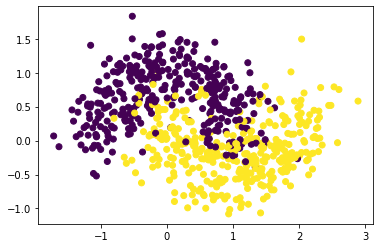

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

current_path = prefix + customized_path_to_your_data
X_train = np.loadtxt(current_path + '/data/X1_train.csv', delimiter=',')
X_test = np.loadtxt(current_path + '/data/X1_test.csv', delimiter=',')
y_train = np.loadtxt(current_path + '/data/y1_train.csv', delimiter=',')
y_test = np.loadtxt(current_path + '/data/y1_test.csv', delimiter=',')

# Plot it to see why is it called two-moon dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

Now, let's create a PyTorch `DataLoader`:

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
batch_size = 64 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = True # shuffle the dataset

# Convert numpy array import torch tensor
X_val = torch.FloatTensor(X_train[500:])
X_train = torch.FloatTensor(X_train[:500])
X_test = torch.FloatTensor(X_test)
y_val = torch.LongTensor(y_train.reshape(-1, 1)[500:])
y_train = torch.LongTensor(y_train.reshape(-1, 1)[:500])
y_test = torch.LongTensor(y_test.reshape(-1, 1))

# First, create a dataset from torch tensor. A dataset define how to read data
# and process data for creating mini-batches.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          num_workers=num_workers, shuffle=shuffle)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
X_train.size()

torch.Size([500, 2])

In [ ]:
epoch = 5 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well
model = nn.Linear(X_train.size(1), 1)
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
    loss_epoch = 0
    # loop through train loader to get x and y
    for x, y in train_loader:
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = (y_pred - y.float()).abs().mean()
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epcoh 0: 4.533509612083435
Epcoh 1: 3.764435738325119
Epcoh 2: 3.0738088488578796
Epcoh 3: 2.5101151317358017
Epcoh 4: 2.2424336671829224


In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, H)
        self.linear3 = nn.Linear(H, D_out) 

    def forward(self, x):
        relu = nn.ReLU()
        hidden_one = relu(self.linear1(x))
        relu =  nn.ReLU()
        hidden_two = relu(self.linear2(hidden_one))
        Sigmoid = nn.Sigmoid()
        y_pred = Sigmoid(self.linear3(hidden_two))

        return y_pred



In [ ]:
def Solver(model, train_loader, optim, criterion, epoch=501, lr=1e-1, print_every=20):

  lossd = nn.BCELoss()
  for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
          optim.zero_grad()
          y_pred = model(x)
#             print(y_pred, y)
          loss = lossd(y_pred, y.float())
          loss.backward()
          optim.step()
          loss_epoch += loss.item()
     
  if e % print_every == 0:
    y_pred = (model(X_train) > 0.5)
    train_acc = get_acc(y_pred, y_train)
    y_val_pred = (model(X_val) > 0.5)
    val_acc = get_acc(y_val_pred, y_val)  
    print(f'Epcoh {e}: {loss_epoch}, Training accuracy: {train_acc}, Validation accuracy: {val_acc}')

  return model


In [ ]:
def get_acc(pred, y):
    pred = pred.float()
    y = y.float()
    return (y==pred).sum().float()/y.size(0)*100.

In [ ]:
epoch=20
lr=1e-1

model = SimpleNN(X_train.size(1),20, 1)
optim = torch.optim.SGD(model.parameters(), lr=lr)

# train your model
model = Solver(model, train_loader, optim, criterion, epoch=epoch, lr=lr, print_every=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
y_pred = (model(X_train) > 0.5)
train_acc = get_acc(y_pred, y_train)

y_val_pred = (model(X_val) > 0.5)
val_acc = get_acc(y_val_pred, y_val)  

y_pred = (model(X_test) > 0.5)
test_acc = get_acc(y_pred, y_test)
print(f'Training accuracy: {train_acc}, Validation accuracy: {val_acc}, Testing accuracy: {test_acc}')

Training accuracy: 84.5999984741211, Validation accuracy: 84.0, Testing accuracy: 84.33332824707031


Evaluate your accuracy:

# Section 3. Image Classification with CNN 
Now, we are back to the image classification problem. Our goal is to, again, train models on CIFAR-10 to perform image classification. We will:
1. Build and Train a simple feed-forward Neural Network (consists of only nn.Linear layer with activation function) for the classification task
2. Build and Train a **Convolutional** Neural Network (CNN) for the classification task
3. Try different settings for training CNN
4. Reproduce

In the following cell, we provide the code for creating a CIFAR10 dataloader. As you can see, PyTorch's `torchvision` package actually has an interface for the CIFAR10 dataset: 

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

current_path = prefix + customized_path_to_your_data
# This will automatically download the dataset for you
trainset = torchvision.datasets.CIFAR10(root=current_path + '/data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=current_path + '/data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super().__init__()
       
        self.linear1 = nn.Linear(D_in,H)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(H, D_out)
        self.sigmoid = nn.Sigmoid()
        pass

        
    def forward(self, x):
        # note that: here, the data is of the shape (B, C, H, W)
        # where B is the batch size, C is color channels, and H
        # and W is height and width.
        # To feed it into the linear layer, we need to reshape it
        # with .view() function.
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # reshape the data from (B, C, H, W) to (B, C*H*W)
        
        out1 = self.linear1(x)
        out2 = self.relu(out1)
        # y_pred  = F.Sigmoid(self.relu(self.linear2(out2)))
        y_pred = self.linear2(out2)
        y_pred = self.sigmoid(y_pred)
        return y_pred
        pass
        

In [ ]:
epoch = 10
lr = 1e-2
n_input = 3072
H = 1000
n_classes = 10

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


model = SimpleNN(n_input,H,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=opt.lr, weight_decay=opt.wd)

for epoch in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        n_input, n_classes = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(n_input)
        loss = criterion(outputs, n_classes)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
def get_model_acc(model, loader):
    ys = []
    y_preds = []
    for x, y in loader:
        ys.append(y)
        # set the prediction to the one that has highest value
        # Note that the the output size of model(x) is (B, 10)
        y_preds.append(torch.argmax(model(x), dim=1))
    y = torch.cat(ys, dim=0)
    y_pred = torch.cat(y_preds, dim=0)
    print((y == y_pred).sum())
    return get_acc(y_pred, y)

In [ ]:
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(29013)
tensor(5117)
Training accuracy: 58.025997161865234, Testing accuracy: 51.16999816894531


## 3.2 Convolutional Neural Network (CNN)
Convolutional layer has been proven to be extremely useful for vision-based task. As mentioned in the lecture, this speical layer allows the model to learn filters that capture crucial visual features. 



### 3.2.1 Implement and Evaluate CNN 
In this section, we will need to construct a CNN for classifying CIFAR-10 image. Specifically, we need to:
1. build a `CNNClassifier` with `nn.Conv2d`, `nn.Maxpool2d` and activation functions that we think are appropriate. 
2. We would need to flatten the output of our convolutional networks with `view()`, and feed it into a `nn.Linear` layer to predict the class labels of the input. 

In [ ]:
import torch.nn.functional as F
class CNNClassifier(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier, self).__init__()
     
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass    
       
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      

In [ ]:
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
model = CNNClassifier(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)

[1,   782] loss: 0.667
[2,   782] loss: 0.521
[3,   782] loss: 0.461
[4,   782] loss: 0.428
[5,   782] loss: 0.400
[6,   782] loss: 0.382
[7,   782] loss: 0.362
[8,   782] loss: 0.348
[9,   782] loss: 0.336
[10,   782] loss: 0.322


CNNClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(37002)
tensor(6385)
Training accuracy: 74.00399780273438, Testing accuracy: 63.849998474121094


I chose the initial size of the image as 32 and the Filter size as 3 with a default Pooling layer of 2 to satisfy the Formula of finding the relevant values: (W-F + 2P/S) + 1. W = Input F = Filter Size, P = Padding, S = Stride.

When I put the values in the Formula I got my new input values. Apart from the input value I experimented with the choice of output layers to make the model accurate

In [ ]:
import torch.nn.functional as F
class CNNClassifier_Two(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_Two, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass    
        
        
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def Solver_Two(model, train_loader, optim, criterion, epoch=501, lr=1e-1, print_every=20):

  # model = SimpleNN(D_in, H, D_out)
  # criterion = nn.BCELoss()
  # optim = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        n_input, n_classes = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(n_input)
        loss = criterion(outputs, n_classes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss / 2000))
    running_loss = 0.0
  return model


In [ ]:
# You can tune these hyperparameters as you like.

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Enter your code here.                                                        
model = CNNClassifier_Two(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)

start = timeit.default_timer()

#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start) 


[1,   782] loss: 0.735
[2,   782] loss: 0.550
[3,   782] loss: 0.491
[4,   782] loss: 0.454
[5,   782] loss: 0.423
[6,   782] loss: 0.402
[7,   782] loss: 0.384
[8,   782] loss: 0.368
[9,   782] loss: 0.353
[10,   782] loss: 0.340
Time:  2.6020001314464025e-05


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(35127)
tensor(6251)
Training accuracy: 70.25399780273438, Testing accuracy: 62.51000213623047


In [ ]:
import torch.nn.functional as F
class CNNClassifier_Three(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_Three, self).__init__()
       
        self.conv1 = nn.Conv2d(3, 12, 3,padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding = 1)
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass    
        
        
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_Three(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)

start = timeit.default_timer()

stop = timeit.default_timer()

print('Time: ', stop - start) 


[1,   782] loss: 0.792
[2,   782] loss: 0.562
[3,   782] loss: 0.463
[4,   782] loss: 0.401
[5,   782] loss: 0.360
[6,   782] loss: 0.334
[7,   782] loss: 0.316
[8,   782] loss: 0.300
[9,   782] loss: 0.284
[10,   782] loss: 0.275
Time:  2.9666000045835972e-05


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(38431)
tensor(6880)
Training accuracy: 76.86199951171875, Testing accuracy: 68.80000305175781


In [ ]:
class CNNClassifier_Four(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_Four, self).__init__()
  
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 5, padding=2)
        self.fc1 = nn.Linear(256 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass    
        
        
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


model = CNNClassifier_Four(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)

start = timeit.default_timer()

#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start)



[1,   782] loss: 0.838
[2,   782] loss: 0.607
[3,   782] loss: 0.472
[4,   782] loss: 0.390
[5,   782] loss: 0.326
[6,   782] loss: 0.279
[7,   782] loss: 0.244
[8,   782] loss: 0.216
[9,   782] loss: 0.188
[10,   782] loss: 0.163
Time:  3.08639991999371e-05


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(44138)
tensor(7227)
Training accuracy: 88.2760009765625, Testing accuracy: 72.2699966430664


In [ ]:
class CNNClassifier_Five(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_Five, self).__init__()
    
        self.conv1 = nn.Conv2d(3, 16, 5, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=3)
        self.conv3 = nn.Conv2d(32, 64, 5,padding=3)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=3)
        self.conv5 = nn.Conv2d(128, 256, 5, padding=3)
        self.conv6 = nn.Conv2d(256, 512,5,padding=3)
        self.fc1 = nn.Linear(512 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass    
        
    def forward(self, x):
  
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


model = CNNClassifier_Five(n_input,n_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)

start = timeit.default_timer()

#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start) 


[1,   782] loss: 0.900
[2,   782] loss: 0.757
[3,   782] loss: 0.608
[4,   782] loss: 0.489
[5,   782] loss: 0.402
[6,   782] loss: 0.343
[7,   782] loss: 0.300
[8,   782] loss: 0.259
[9,   782] loss: 0.221
[10,   782] loss: 0.197
Time:  2.513299841666594e-05


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(42553)
tensor(7116)
Training accuracy: 85.10599517822266, Testing accuracy: 71.16000366210938


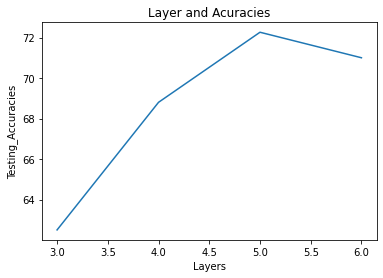

In [ ]:
import matplotlib.pyplot as plt
   
Layers = [3,4,5,6]
Testing_Accuracies = [62.5,68.8,72.26,71]
  
plt.plot(Layers, Testing_Accuracies)
plt.title('Layer and Acuracies')
plt.xlabel('Layers')
plt.ylabel('Testing_Accuracies')
plt.show()



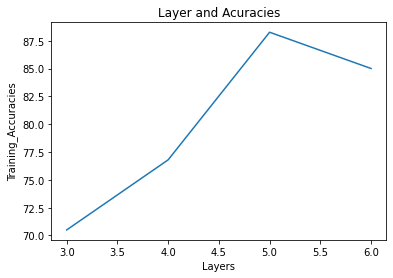

In [ ]:
Layers = [3,4,5,6]
Training_Accuracies = [70.5,76.8,88.27,85.01]
  
plt.plot(Layers, Training_Accuracies)
plt.title('Layer and Acuracies')
plt.xlabel('Layers')
plt.ylabel('Training_Accuracies')
plt.show()

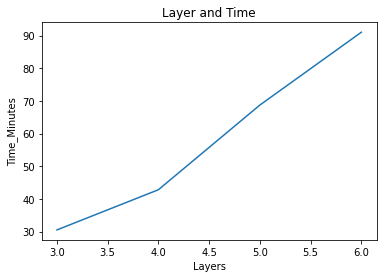

In [ ]:
Layers = [3,4,5,6]
Time_Minutes = [30.5,42.8,68.72,91.01]
  
plt.plot(Layers, Time_Minutes)
plt.title('Layer and Time')
plt.xlabel('Layers')
plt.ylabel('Time_Minutes')
plt.show()

### 3.2.3 Optimizer? Optimizer! 
So far, we only use SGD as our optimizer. **Now, we pick two other optimizers, train our CNN models, and compare the performance we get. 

In [ ]:

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


model = CNNClassifier_Five(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))


[1,   782] loss: 0.821
[2,   782] loss: 0.634
[3,   782] loss: 0.503
[4,   782] loss: 0.423
[5,   782] loss: 0.365
[6,   782] loss: 0.327
[7,   782] loss: 0.295
[8,   782] loss: 0.267
[9,   782] loss: 0.248
[10,   782] loss: 0.230
--- 5.4836273193359375e-05 seconds ---


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(39778)
tensor(6808)
Training accuracy: 79.55599975585938, Testing accuracy: 68.08000183105469


In [ ]:
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_Five(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

[1,   782] loss: 0.710
[2,   782] loss: 0.506
[3,   782] loss: 0.414
[4,   782] loss: 0.357
[5,   782] loss: 0.315
[6,   782] loss: 0.278
[7,   782] loss: 0.245
[8,   782] loss: 0.214
[9,   782] loss: 0.188
[10,   782] loss: 0.164
--- 5.459785461425781e-05 seconds ---


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(44961)
tensor(6928)
Training accuracy: 89.9219970703125, Testing accuracy: 69.27999877929688


In [ ]:

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


model = CNNClassifier_Four(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)

start = time.time()
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

[1,   782] loss: 0.720
[2,   782] loss: 0.532
[3,   782] loss: 0.433
[4,   782] loss: 0.366
[5,   782] loss: 0.320
[6,   782] loss: 0.287
[7,   782] loss: 0.259
[8,   782] loss: 0.233
[9,   782] loss: 0.215
[10,   782] loss: 0.198
00:00:00.00


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(41444)
tensor(6947)
Training accuracy: 82.88800048828125, Testing accuracy: 69.47000122070312


In [ ]:
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_Four(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)
start_time = time.time()

print("--- %s seconds ---" % (time.time() - start_time))

[1,   782] loss: 0.651
[2,   782] loss: 0.462
[3,   782] loss: 0.377
[4,   782] loss: 0.318
[5,   782] loss: 0.272
[6,   782] loss: 0.234
[7,   782] loss: 0.201
[8,   782] loss: 0.169
[9,   782] loss: 0.141
[10,   782] loss: 0.119
--- 7.43865966796875e-05 seconds ---


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(45765)
tensor(6948)
Training accuracy: 91.52999877929688, Testing accuracy: 69.4800033569336


In [ ]:
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


model = CNNClassifier_Three(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)
start_time = time.time()

print("--- %s seconds ---" % (time.time() - start_time))



[1,   782] loss: 0.675
[2,   782] loss: 0.492
[3,   782] loss: 0.423
[4,   782] loss: 0.385
[5,   782] loss: 0.358
[6,   782] loss: 0.338
[7,   782] loss: 0.321
[8,   782] loss: 0.308
[9,   782] loss: 0.298
[10,   782] loss: 0.289
--- 5.9604644775390625e-05 seconds ---


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(35345)
tensor(6311)
Training accuracy: 70.69000244140625, Testing accuracy: 63.11000061035156


In [ ]:

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
                                                    #
model = CNNClassifier_Three(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)
start_time = time.time()

print("--- %s seconds ---" % (time.time() - start_time))
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')


[1,   782] loss: 0.626
[2,   782] loss: 0.490
[3,   782] loss: 0.429
[4,   782] loss: 0.388
[5,   782] loss: 0.354
[6,   782] loss: 0.327
[7,   782] loss: 0.308
[8,   782] loss: 0.295
[9,   782] loss: 0.277
[10,   782] loss: 0.264
--- 5.7220458984375e-05 seconds ---
tensor(37918)
tensor(6817)
Training accuracy: 75.83600616455078, Testing accuracy: 68.16999816894531


### 3.2.4 Improve The Model 

Again, we want you to play with the model a bit harder, and improve it. 

In [ ]:

class CNNClassifier_Best(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_Best, self).__init__()
      
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 5, padding=2)
        self.fc1 = nn.Linear(256 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)
        pass    
     
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(self.fc3(x))
        # x = self.fc3(x)
        return x
        

In [ ]:
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_Best(n_input,n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
Solver_Two(model, train_loader, optimizer, criterion, epoch, lr)


[1,   782] loss: 0.874
[2,   782] loss: 0.776
[3,   782] loss: 0.709
[4,   782] loss: 0.660
[5,   782] loss: 0.615
[6,   782] loss: 0.589
[7,   782] loss: 0.565
[8,   782] loss: 0.543
[9,   782] loss: 0.527
[10,   782] loss: 0.509


CNNClassifier_Best(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(40779)
tensor(7233)
Training accuracy: 81.55799865722656, Testing accuracy: 72.33000183105469
